In [1]:
!pip install MetaTrader5 matplotlib mplfinance

[-1  0  1  0  0 -1  0  0  0]
close_time
2025-07-11 00:18:00    145.86
2025-07-11 00:19:00    145.87
2025-07-11 00:20:00    145.86
2025-07-11 00:21:00    145.88
2025-07-11 00:22:00    145.92
2025-07-11 00:23:00    145.91
2025-07-11 00:24:00    145.94
2025-07-11 00:25:00    145.89
2025-07-11 00:26:00    145.95
2025-07-11 00:27:00    145.99
2025-07-11 00:28:00    146.01
2025-07-11 00:29:00    146.02
2025-07-11 00:30:00    146.01
2025-07-11 00:31:00    146.02
2025-07-11 00:32:00    145.99
2025-07-11 00:33:00    145.93
2025-07-11 00:34:00    145.93
2025-07-11 00:35:00    145.97
2025-07-11 00:36:00    146.04
2025-07-11 00:37:00    146.02
Name: close, dtype: float64
(array([-1,  0,  1]), array([  49, 1325,   48]))
1422 1422
[-1  0  0  0  0  0  0  0  0  0]
                       open    high     low   close  volumeto
close_time                                                   
2025-07-11 23:55:00  146.88  146.94  146.92  146.92   2487.40
2025-07-11 23:56:00  146.90  146.91  146.88  146.91    

c:\Users\miya4\anaconda3\envs\tf\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25276 (\N{CJK UNIFIED IDEOGRAPH-62BC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\miya4\anaconda3\envs\tf\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\miya4\anaconda3\envs\tf\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\miya4\anaconda3\envs\tf\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36023 (\N{CJK UNIFIED IDEOGRAPH-8CB7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\miya4\anaconda3\envs\tf\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12356 (\N{HIRAGANA LETTER I}) missing 

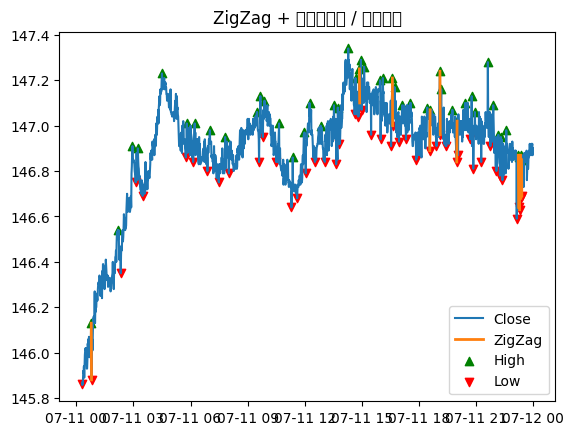

ValueError: too many values to unpack (expected 2)

In [2]:
# === モジュールインポート ===
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import time
import requests
import talib
import datetime
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt


# === 初期設定 ===
SYMBOL = "USD"
TO_SYMBOL = "JPY"
TIMEFRAME = mt5.TIMEFRAME_M1
MAX_BARS = 500
SL_PIPS = 3
TP_PIPS = 6
POSITION_SIZE = 0.1

# === MT5接続 ===
mt5.initialize()

# === データ取得 ===
def fetch_data(SYMBOL, TO_SYMBOL):
    price = []
    params = {"fsym": SYMBOL, "tsym": TO_SYMBOL, "limit": 2000}
    while True:
        try:
            response = requests.get("https://min-api.cryptocompare.com/data/histominute", params, timeout=10)
            data = response.json()
            if data.get("Response") != "Success" or not data.get("Data"):
                time.sleep(10)
                continue
            break
        except Exception:
            time.sleep(10)

    for i in data["Data"]:
        price.append({
            "close_time": i["time"],
            "open": i["open"],
            "high": i["high"],
            "low": i["low"],
            "close": i["close"],
            "volumeto": i["volumeto"]
        })
    df = pd.DataFrame(price)
    df['close_time'] = pd.to_datetime(df['close_time'], unit='s')
    df.set_index('close_time', inplace=True)
    for col in ['open', 'high', 'low', 'close', 'volumeto']:
        df[col] = df[col].astype(float)
    return df
def calc_slope(line, window=5):
    """
    line: 高値ラインや安値ラインのリスト
    window: 傾きを計算する期間
    return: 傾き（1本あたりの増減量）
    """
    if len(line) < window:
        return 0
    y = np.array(line[-window:])
    x = np.arange(window)
    # 最小二乗法で傾き計算
    slope = np.polyfit(x, y, 1)[0]
    return slope
# === ZigZag計算 ===
import numpy as np

def peak_valley_pivots(close, up_thresh=0.001, down_thresh=0.001):
    """
    ZigZagの山谷検出（jbn/ZigZagと同等）
    
    Parameters:
        close: 価格の配列（list または np.array）
        up_thresh: 高値への転換を検出する割合（例：0.02 = +2%）
        down_thresh: 安値への転換を検出する割合（例：0.02 = -2%）
    
    Returns:
        pivots: numpy array（1=高値、-1=安値、0=ノイズ）
    """
    close = np.asarray(close)
    pivots = np.zeros(len(close), dtype=int)

    if len(close) < 2:
        return pivots

    trend = 0  # 1 = up, -1 = down
    last_pivot = 0

    for i in range(1, len(close)):
        change = (close[i] - close[last_pivot]) / close[last_pivot]

        if trend == 0:
            if change > up_thresh:
                trend = 1
                pivots[last_pivot] = -1  # 安値
                last_pivot = i
            elif change < -down_thresh:
                trend = -1
                pivots[last_pivot] = 1   # 高値
                last_pivot = i

        elif trend == -1:
            if close[i] < close[last_pivot]:
                last_pivot = i
            elif (close[i] - close[last_pivot]) / close[last_pivot] > up_thresh:
                pivots[last_pivot] = -1  # 安値
                last_pivot = i
                trend = 1

        elif trend == 1:
            if close[i] > close[last_pivot]:
                last_pivot = i
            elif (close[i] - close[last_pivot]) / close[last_pivot] < -down_thresh:
                pivots[last_pivot] = 1  # 高値
                last_pivot = i
                trend = -1

    return pivots

def calc_zigzag(df, pct=0.001):
    """
    ZigZagでスイングの高値安値（pivot）を取得
    """
    closes = df['close'].values
    pivots = peak_valley_pivots(closes, up_thresh=pct, down_thresh=pct)
    df['pivot'] = pivots

    df['zigzag'] = np.nan
    df.loc[df['pivot'] != 0, 'zigzag'] = df['close']

    return df

# === シグナル生成（ADX条件付き） ===
def judge_trade_dp(df, high_lines, low_lines, margin=0.0, adx_period=14, adx_th=20, slope_window=20, slope_th=0.01, atr_th_ratio=0.3):
    """
    ZigZagから押し目買い / 戻り売りのトレードチャンスを判定
    """
    signals = []
    zz = df['zigzag'].values
    price = df['close'].values

    for i in range(2, len(df)):
        # 直近3つのzigzagポイントを見てトレンド判定
        recent_zz = zz[i-3:i+1]
        recent_idx = np.where(~np.isnan(recent_zz))[0]

        if len(recent_idx) < 3:
            signals.append(None)
            continue

        p0 = recent_zz[recent_idx[-3]]
        p1 = recent_zz[recent_idx[-2]]
        p2 = recent_zz[recent_idx[-1]]

        # 上昇トレンド中の押し目買い条件
        if p0 < p1 > p2 and price[i] > p2:
            signals.append('buy')

        # 下降トレンド中の戻り売り条件
        elif p0 > p1 < p2 and price[i] < p2:
            signals.append('sell')
        else:
            signals.append(None)

    df['signal'] = [None]*2 + signals
    return df


def fit_lines_smooth(series, window=41, poly=3, margin=0.0):
    high_line = savgol_filter(series.rolling(window=window, min_periods=1).max(), window_length=window, polyorder=poly)
    low_line = savgol_filter(series.rolling(window=window, min_periods=1).min(), window_length=window, polyorder=poly)
    return (high_line * (1 + margin)).tolist(), (low_line * (1 - margin)).tolist()

# === 勝率計算関数（時間制限型） ===
def calc_winrate(df, open_, close, high, low, entry_minutes=10, tp_trend_pips=8, sl_trend_pips=4, tp_range_pips=4, sl_range_pips=2, spread=0.02, symbol="USDJPY", lot=1000, start_balance=50000, leverage=3):
    high_lines, low_lines = fit_lines_smooth(df['high'], window=40)
    signals,_ = judge_trade_dp(df, high_lines, low_lines)
    entries, results = [], []
    pips_unit = 0.01 if "JPY" in symbol else 0.0001
    tp_trend_value = tp_trend_pips * pips_unit
    sl_trend_value = sl_trend_pips * pips_unit
    tp_range_value = tp_range_pips * pips_unit
    sl_range_value = sl_range_pips * pips_unit

    open_, close = open_.reset_index(drop=True), close.reset_index(drop=True)
    high, low = high.reset_index(drop=True), low.reset_index(drop=True)
    balance = start_balance
    balance_curve = [balance]

    for i, sig in enumerate(signals):
        if sig in ("TREND_UP", "REVERSE_UP", "TREND_DOWN", "REVERSE_DOWN") and i + entry_minutes + 1 < len(close):
            entry_price = open_[i + 1] + spread if sig in ("TREND_UP", "REVERSE_UP") else open_[i + 1] - spread
            high_seq = high[i + 1 : i + 1 + entry_minutes]
            low_seq = low[i + 1 : i + 1 + entry_minutes]
            win = False

            if sig in ("TREND_UP", "REVERSE_UP"):
                if (high_seq >= entry_price + tp_trend_value).any() and not (low_seq <= entry_price - sl_trend_value).any():
                    balance += lot * tp_trend_value * leverage
                    win = True
                elif (low_seq <= entry_price - sl_trend_value).any():
                    balance -= lot * sl_trend_value * leverage
                else:
                    exit_price = close[i + 1 + entry_minutes]
                    profit = (exit_price - entry_price - spread) * lot * leverage
                    balance += profit
                    win = profit > 0
            elif sig in ("TREND_DOWN", "REVERSE_DOWN"):
                if (low_seq <= entry_price - tp_range_value).any() and not (high_seq >= entry_price + sl_range_value).any():
                    balance += lot * tp_range_value * leverage
                    win = True
                elif (high_seq >= entry_price + sl_range_value).any():
                    balance -= lot * sl_range_value * leverage
                else:
                    exit_price = close[i + 1 + entry_minutes]
                    profit = (entry_price - exit_price - spread) * lot * leverage
                    balance += profit
                    win = profit > 0

            entries.append(i)
            results.append(win)
            balance_curve.append(balance)
            if balance <= 0:
                break

    winrate = sum(results) / len(results) if results else None
    if winrate is not None:
        print(f"[WinRate] {winrate:.2%} ({len(results)} trades)")
    else:
        print(f"[WinRate] N/A (0 trades)")
    print(f"[Final Balance] {balance:.2f} / Drawdown: {max(balance_curve) - min(balance_curve):.2f}")
    return winrate, entries, results, signals

# === 勝率計算関数（TP/SL成立まで追跡型） ===
def calc_winrate2(df, open_, close, high, low, tp_trend_pips=8, sl_trend_pips=4, tp_range_pips=4, sl_range_pips=2, spread=0.02, symbol="USDJPY", lot=1000, start_balance=50000, leverage=3):
    high_lines, low_lines = dp_fit_lines(df['high'])
    signals,_ = judge_trade_dp(df, high_lines, low_lines)
    entries, results = [], []
    pips_unit = 0.01 if "JPY" in symbol else 0.0001
    tp_trend_value = tp_trend_pips * pips_unit
    sl_trend_value = sl_trend_pips * pips_unit
    tp_range_value = tp_range_pips * pips_unit
    sl_range_value = sl_range_pips * pips_unit
    open_, close = open_.reset_index(drop=True), close.reset_index(drop=True)
    high, low = high.reset_index(drop=True), low.reset_index(drop=True)
    balance = start_balance
    balance_curve = [balance]

    for i, sig in enumerate(signals):
        if sig in ("TREND_UP", "REVERSE_UP", "TREND_DOWN", "REVERSE_DOWN") and i + 1 < len(open_):
            entry_price = open_[i + 1] + spread if sig in ("TREND_UP", "REVERSE_UP") else open_[i + 1] - spread
            t = 1
            hit = None
            while i + 1 + t < len(df):
                high_t = high[i + 1 + t]
                low_t = low[i + 1 + t]
                if sig in ("TREND_UP", "REVERSE_UP"):
                    if high_t >= entry_price + tp_trend_value:
                        balance += lot * tp_trend_value * leverage
                        hit = True
                        break
                    elif low_t <= entry_price - sl_trend_value:
                        balance -= lot * sl_trend_value * leverage
                        hit = False
                        break
                elif sig in ("TREND_DOWN", "REVERSE_DOWN"):
                    if low_t <= entry_price - tp_range_value:
                        balance += lot * tp_range_value * leverage
                        hit = True
                        break
                    elif high_t >= entry_price + sl_range_value:
                        balance -= lot * sl_range_value * leverage
                        hit = False
                        break
                t += 1

            if hit is None:
                exit_price = close[min(i + 1 + t, len(close) - 1)]
                profit = (exit_price - entry_price - spread) * lot * leverage if sig in ("TREND_UP", "REVERSE_UP") else (entry_price - exit_price - spread) * lot * leverage
                balance += profit
                hit = profit > 0

            entries.append(i)
            results.append(hit)
            balance_curve.append(balance)
            if balance <= 0:
                break

    
    winrate = sum(results) / len(results) if results else None
    if winrate is not None:
        print(f"[WinRate] {winrate:.2%} ({len(results)} trades)")
    else:
        print(f"[WinRate] N/A (0 trades)")
    print(f"[Final Balance] {balance:.2f} / Drawdown: {max(balance_curve) - min(balance_curve):.2f}")
    return winrate, entries, results, signals

# === 発注関数 ===
def place_order(symbol, signal):
    """
    signal: "TREND_UP", "TREND_DOWN", "REVERSE_UP", "REVERSE_DOWN"
    TREND_UP/REVERSE_UP → buy, TREND_DOWN/REVERSE_DOWN → sell
    """
    if signal in ("TREND_UP", "REVERSE_UP"):
        order_type = 'buy'
        price = mt5.symbol_info_tick(symbol).ask
        sl = price - SL_PIPS * 0.01
        tp = price + TP_PIPS * 0.01
        order_type_mt5 = mt5.ORDER_TYPE_BUY
    elif signal in ("TREND_DOWN", "REVERSE_DOWN"):
        order_type = 'sell'
        price = mt5.symbol_info_tick(symbol).bid
        sl = price + SL_PIPS * 0.01
        tp = price - TP_PIPS * 0.01
        order_type_mt5 = mt5.ORDER_TYPE_SELL
    else:
        return "No order: invalid signal"

    deviation = 5
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": POSITION_SIZE,
        "type": order_type_mt5,
        "price": price,
        "sl": sl,
        "tp": tp,
        "deviation": deviation,
        "magic": 123456,
        "comment": f"ScalpBot_{signal}",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }
    result = mt5.order_send(request)
    return result

test_prices = [1, 1.02, 1.05, 1.03, 0.98, 0.95, 1.0, 1.1, 1.15]
pivots = peak_valley_pivots(test_prices, up_thresh=0.02, down_thresh=0.02)
print(pivots)
# === データ取得と勝率計算 ===

df = fetch_data(SYMBOL, TO_SYMBOL)
df = df[df.index.weekday < 5]
# 1. データの確認
print(df['close'].head(20))  # 価格データの最初の20行

# 2. しきい値を小さくして再実行
pivots = peak_valley_pivots(df['close'])
print(np.unique(pivots, return_counts=True))

# 3. pivotsの配列長とdfの長さを比較
print(len(pivots), len(df))

# 4. pivots配列の先頭10個を表示
print(pivots[:10])
print(df.tail())
df = calc_zigzag(df)
plt.plot(df['close'], label='Close')
plt.plot(df['zigzag'], label='ZigZag', linewidth=2)
print("ZigZag Points:" , df['zigzag'].dropna().index.tolist())
print(df.columns)

# マーカー表示（高値・安値）
plt.scatter(df.index[df['pivot'] == 1], df['close'][df['pivot'] == 1], color='green', marker='^', label='High')
plt.scatter(df.index[df['pivot'] == -1], df['close'][df['pivot'] == -1], color='red', marker='v', label='Low')

plt.legend()
plt.title('ZigZag + 押し目買い / 戻り売り')
plt.show()
calc_winrate(df, df['open'], df['close'], df['high'], df['low'])
calc_winrate2(df, df['open'], df['close'], df['high'], df['low'])

interval_minutes = 1  # 1分ごとに実行]
last_run_minute = None

